%%markdown

Implement a Helmholtz 2D problem for the acoustic duct:

Here we solve for both the real and imaginary part

$$\Delta w(x,y) +k^2w(x,y) = 0 \quad \text{for} \quad (x,y) \in \Omega:= (0,2) \times (0,1)$$

with Neumann and Robin boundary conditions:

$$\frac{\partial u}{\partial n} = \cos(m\pi x), \quad \text{for} \quad x = 0$$

$$\frac{\partial u}{\partial n} = -iku, \quad \text{for} \quad x = 2$$

$$\frac{\partial u}{\partial n} = 0, \quad \text{for} \quad y = 0 \quad \text{and} \quad y = 1$$

Exact solution:

$$u(x,y) = \cos(m\pi y)\left(A_1 e^{-i k_x x} + A_2 e^{i k_x x}\right)$$

where $A_1$ and $A_2$ are obtained by solving the $2 \times 2$ linear system:

$$
\begin{bmatrix}
i k_x & -i k_x \\
i(k - k_x)e^{-2i k_x} & i(k + k_x)e^{2i k_x}
\end{bmatrix}
\begin{bmatrix}
A_1 \\
A_2
\end{bmatrix}
=
\begin{bmatrix}
1 \\
0
\end{bmatrix}
$$

In [3]:
import sys
sys.path.append('..')

from utils.tfp_loss import tfp_function_factory
from utils.Geom_examples import Quadrilateral
from utils.Solvers import Helmholtz2D_coll


In [5]:
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from utils.tfp_loss import tfp_function_factory
from utils.Geom_examples import Quadrilateral
from utils.Solvers import Helmholtz2D_coll
from utils.Plotting import plot_convergence_semilog

tf.random.set_seed(42)

In [6]:
#define model parameters
m = 1 #mode number
k = 4 #wave number
alpha = 1j*k # coefficient for Robin boundary conditions of the form 
             #   du/dn + alpha*u = g

#solve for the constants A1 and A2 in the exact solution
kx = np.sqrt(k ** 2 - (m * np.pi) ** 2)
LHS = np.array(
    [[1j*kx , -1j * kx], [1j*(k - kx) * np.exp(-2j * kx), 1j*(k + kx) * np.exp(2j * kx)]]
)
RHS = np.array([1.0, 0.0])
A = np.linalg.solve(LHS, RHS)


# The exact solution for error norm computations
def exact_sol(x, y):
    return np.cos(m * np.pi * y) * (
        A[0] * np.exp(-1j * kx * x) + A[1] * np.exp(1j * kx * x)
    )

def deriv_exact_sol(x, y):
    return [
        np.cos(m * np.pi * y)
        * (
            A[0] * (-1j) * kx * np.exp(-1j * kx * x)
            + A[1] * 1j * kx * np.exp(1j * kx * x)
        ),
        -np.sin(m * np.pi * y)
        * (m * np.pi)
        * (A[0] * np.exp(-1j * kx * x) + A[1] * np.exp(1j * kx * x)),
    ]

# Define the boundary conditions
def u_bound_left(x, y):
    return np.cos(m * np.pi * y)


def u_bound_right(x, y):
    return 0.0

def u_bound_up_down(x,y):
    return np.zeros_like(x)

    
#define the input and output data set
xmin = 0
xmax = 2
ymin = 0
ymax = 1
domainCorners = np.array([[xmin,ymin], [xmin,ymax], [xmax,ymin], [xmax,ymax]])
myQuad = Quadrilateral(domainCorners)

numPtsU = 28
numPtsV = 28
xPhys, yPhys = myQuad.getUnifIntPts(numPtsU, numPtsV, [0,0,0,0])
data_type = "float64"

Xint = np.concatenate((xPhys,yPhys),axis=1).astype(data_type)
Yint = np.zeros_like(Xint)

In [7]:
# Generate the training data for the Neumann boundary
xPhysNeu, yPhysNeu, xNormNeu, yNormNeu = myQuad.getUnifEdgePts(numPtsU, numPtsV, [1,0,1,1])
XbndNeu = np.concatenate((xPhysNeu, yPhysNeu, xNormNeu, yNormNeu), axis=1).astype(data_type)
dwdx_neu, dwdy_neu = deriv_exact_sol(xPhysNeu, yPhysNeu)

Ybnd_neu_real = np.real(dwdx_neu*XbndNeu[:, 2:3] + dwdy_neu*XbndNeu[:, 3:4])
Ybnd_neu_imag = np.imag(dwdx_neu*XbndNeu[:, 2:3] + dwdy_neu*XbndNeu[:, 3:4])
YbndNeu = np.concatenate((Ybnd_neu_real, Ybnd_neu_imag), axis=1).astype(data_type)

# Generating the training data for the Robin boundary
xPhysRobin, yPhysRobin, xNormRobin, yNormRobin = myQuad.getUnifEdgePts(numPtsU, numPtsV, [0,1,0,0])
XbndRobin = np.concatenate((xPhysRobin, yPhysRobin, xNormRobin, yNormRobin), axis=1).astype(data_type)
Ybnd_robin_real = u_bound_up_down(xPhysRobin, yPhysRobin)
Ybnd_robin_imag = u_bound_up_down(xPhysRobin, yPhysRobin)
YbndRobin = np.concatenate((Ybnd_robin_real, Ybnd_robin_imag), axis=1).astype(data_type)

#define the model 
tf.keras.backend.set_floatx(data_type)
l1 = tf.keras.layers.Dense(20, "tanh")
l2 = tf.keras.layers.Dense(20, "tanh")
l3 = tf.keras.layers.Dense(20, "tanh")
l4 = tf.keras.layers.Dense(2, None)
train_op = tf.keras.optimizers.Adam()
num_epoch = 5000
print_epoch = 100
alpha_real = np.real([alpha]).astype(data_type)[0]
alpha_imag = np.imag([alpha]).astype(data_type)[0]
pred_model = Helmholtz2D_coll([l1, l2, l3, l4], train_op, num_epoch,
                                    print_epoch, k, alpha_real, alpha_imag)

#convert the training data to tensors
Xint_tf = tf.convert_to_tensor(Xint)
Yint_tf = tf.convert_to_tensor(Yint)
XbndNeu_tf = tf.convert_to_tensor(XbndNeu)
YbndNeu_tf = tf.convert_to_tensor(YbndNeu)
XbndRobin_tf = tf.convert_to_tensor(XbndRobin)
YbndRobin_tf = tf.convert_to_tensor(YbndRobin)

In [8]:
#training
print("Training (ADAM)...")
t0 = time.time()
pred_model.network_learn(Xint_tf, Yint_tf, XbndNeu_tf, YbndNeu_tf, XbndRobin_tf, YbndRobin_tf)
t1 = time.time()
print("Time taken (ADAM)", t1-t0, "seconds")
print("Training (BFGS)...")

loss_func = tfp_function_factory(pred_model, Xint_tf, Yint_tf, 
                                 XbndNeu_tf, YbndNeu_tf, XbndRobin_tf, YbndRobin_tf)
#loss_func = scipy_function_factory(pred_model, Xint_tf, Yint_tf, Xbnd_tf, Ybnd_tf)
# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(loss_func.idx, pred_model.trainable_variables)
# train the model with BFGS solver
results = tfp.optimizer.bfgs_minimize(
    value_and_gradients_function=loss_func, initial_position=init_params,
          max_iterations=3000, tolerance=1e-14)

Training (ADAM)...
Epoch 0 loss: 10.226218346244753
Epoch 100 loss: 0.18388930042068785
Epoch 200 loss: 0.17660845552815668
Epoch 300 loss: 0.17246826422276726
Epoch 400 loss: 0.16959729154556777
Epoch 500 loss: 0.16727441417786573
Epoch 600 loss: 0.1651820284536748
Epoch 700 loss: 0.16313668865875142
Epoch 800 loss: 0.1610174073452692
Epoch 900 loss: 0.15876381939236606
Epoch 1000 loss: 0.15634081099760527
Epoch 1100 loss: 0.15367761694064458
Epoch 1200 loss: 0.15070437127460076
Epoch 1300 loss: 0.14744601637255317
Epoch 1400 loss: 0.1440565313676478
Epoch 1500 loss: 0.14068996657442068
Epoch 1600 loss: 0.13734871100654486
Epoch 1700 loss: 0.13392304235860256
Epoch 1800 loss: 0.13031098608738861
Epoch 1900 loss: 0.12665531790864332
Epoch 2000 loss: 0.12285390231296792
Epoch 2100 loss: 0.11876844580535496
Epoch 2200 loss: 0.11421596590015799
Epoch 2300 loss: 0.10921027453616042
Epoch 2400 loss: 0.1044073287731625
Epoch 2500 loss: 0.09947359640577338
Epoch 2600 loss: 0.09442330991692706

In [9]:
# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
loss_func.assign_new_model_parameters(results.position)
#loss_func.assign_new_model_parameters(results.x)
t2 = time.time()
print("Time taken (BFGS)", t2-t1, "seconds")
print("Time taken (all)", t2-t0, "seconds")
print("Testing...")
numPtsUTest = 2*numPtsU
numPtsVTest = 2*numPtsV
xPhysTest, yPhysTest = myQuad.getUnifIntPts(numPtsUTest, numPtsVTest, [1,1,1,1])
XTest = np.concatenate((xPhysTest,yPhysTest),axis=1).astype(data_type)
XTest_tf = tf.convert_to_tensor(XTest)
YTest = pred_model(XTest_tf).numpy()
YTest_real = YTest[:, 0:1]
YTest_imag = YTest[:, 1:2]
YExact = exact_sol(XTest[:,[0]], XTest[:,[1]])
YExact_real = np.real(YExact)
YExact_imag = np.imag(YExact)

xPhysTest2D = np.resize(XTest[:,0], [numPtsUTest, numPtsVTest])
yPhysTest2D = np.resize(XTest[:,1], [numPtsUTest, numPtsVTest])
YExact2D_real = np.resize(YExact_real, [numPtsUTest, numPtsVTest])
YExact2D_imag = np.resize(YExact_imag, [numPtsUTest, numPtsVTest])

YTest2D_real = np.resize(YTest_real, [numPtsUTest, numPtsVTest])
YTest2D_imag = np.resize(YTest_imag, [numPtsUTest, numPtsVTest])

Time taken (BFGS) 5120.302244901657 seconds
Time taken (all) 5720.013241291046 seconds
Testing...


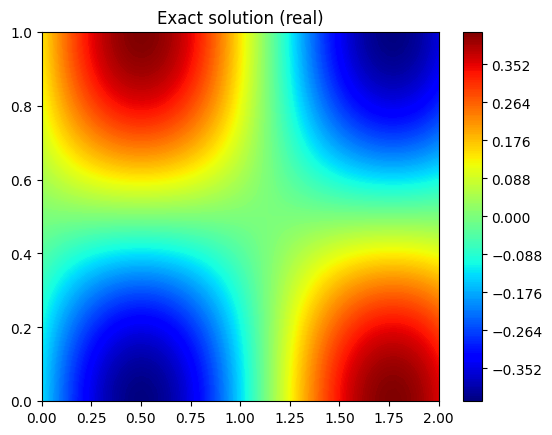

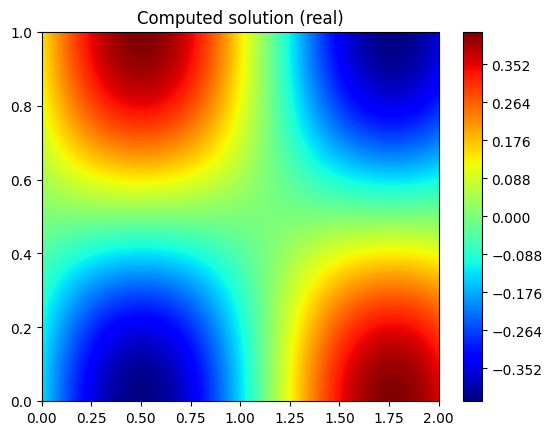

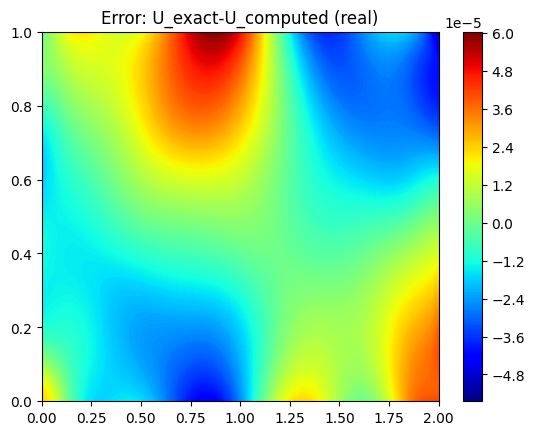

In [10]:
# Plot the real part of the solution and errors
plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D_real, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Exact solution (real)")
plt.show()
plt.contourf(xPhysTest2D, yPhysTest2D, YTest2D_real, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Computed solution (real)")
plt.show()
plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D_real-YTest2D_real, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Error: U_exact-U_computed (real)")
plt.show()

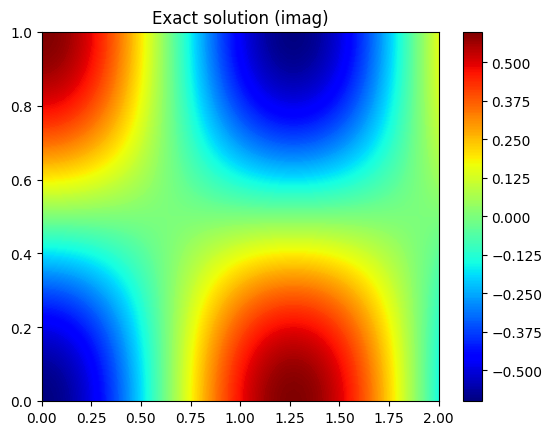

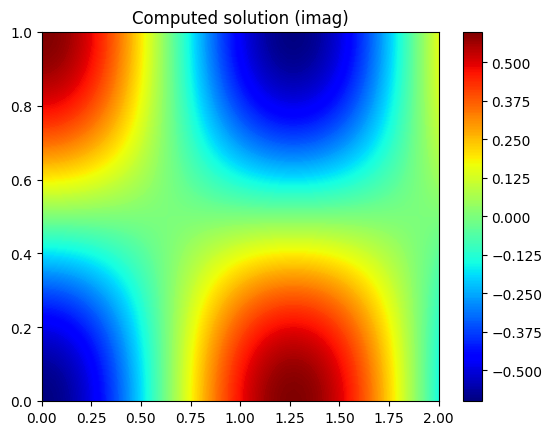

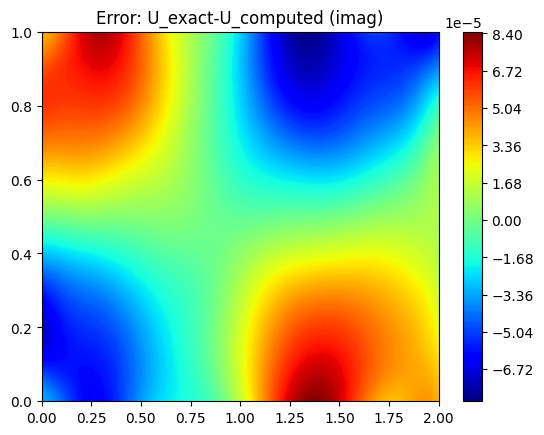

In [11]:
# Plot the imaginary part of the solution and errors
plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D_imag, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Exact solution (imag)")
plt.show()
plt.contourf(xPhysTest2D, yPhysTest2D, YTest2D_imag, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Computed solution (imag)")
plt.show()
plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D_imag-YTest2D_imag, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Error: U_exact-U_computed (imag)")
plt.show()

L2-error norm (real): 8.631015511457741e-05
L2-error norm (imag): 0.00013183218445783184


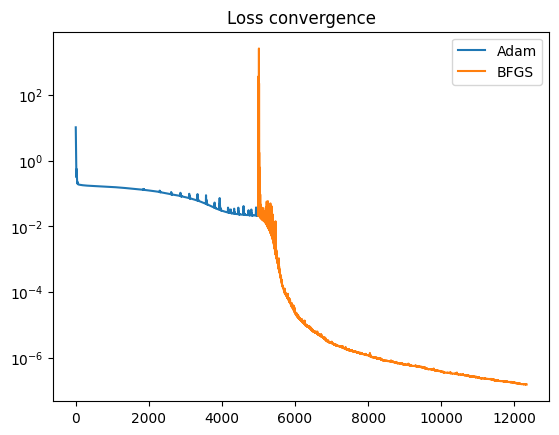

In [12]:
# Compute relative errors
err_real = YExact_real - YTest_real
err_imag = YExact_imag - YTest_imag
print("L2-error norm (real): {}".format(np.linalg.norm(err_real)/np.linalg.norm(YTest_real)))
print("L2-error norm (imag): {}".format(np.linalg.norm(err_imag)/np.linalg.norm(YTest_imag)))

# plot the loss convergence
plot_convergence_semilog(pred_model.adam_loss_hist, loss_func.history)